In [1]:
from collections import namedtuple
from astropy.io.votable import parse_single_table

from astropy.io import fits
from astropy.table import QTable, Column
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from RadioAbsTools import spectrum_tools
from astropy.wcs import WCS

sns.set()

## Build Catalogues of SMC absorption spectra

Takes the spectra and catalogues produced by the GASKAP Absorption pipeline and produces the enhanced catalogues:

* gaskap_smc_spectra.vot
* gaskap_smc_absorption.vot

We use the following extra criteria for spectra to be included in analysis of the SMC:

* continuum noise <= 0.3
* beam_power >= 0.8

### Table of Contents

* [Produce augmented spectra table](#Produce-augmented-spectra-table)
* [Produce restricted absorption table](#Produce-restricted-absorption-table)


### Produce augmented spectra table

In [2]:
# Constants

c0 = 1.823 * 10**18
source_dat_loc = 'sb10944/v3b/'
spectra_loc = '{}/spectra'.format(source_dat_loc)
spectra_cat_loc = '{}/askap_spectra.vot'.format(source_dat_loc)
absorption_cat_loc = '{}/askap_absorption.vot'.format(source_dat_loc)

beam_pattern_loc = 'sb10944/SMC_PB_pattern_full.fits'

In [3]:
def find_emission_window(abs_spec, vel_range):
    em_idxes = np.where((abs_spec['em_mean'] >= 3) & # K
                        (abs_spec['velocity']/1e3 >= vel_range[0] ) & 
                        (abs_spec['velocity']/1e3 <= vel_range[1]) )
    #print (em_idxes, len(em_idxes[0]), em_idxes[0][0], em_idxes[0][-1])
    if len(em_idxes[0]) < 2:
        return None
    return np.array([em_idxes[0][0], em_idxes[0][-1]])


def get_corrected_od(od_samples, measured_od_noise):
    """
    Replace any saturated optical depth measurements with the noise limits
    """
    od = np.zeros(od_samples.shape)
    od += measured_od_noise
    saturated = od_samples <= 0
    od[~saturated] = od_samples[~saturated]
    return od

    
def calc_bulk_tau(od_samples, measured_od_noise):
    od = get_corrected_od(od_samples, measured_od_noise)
    tau = -1*np.log(od)
    
    return tau

def calc_uncorr_nh(em_samples, vel_filter):
    nh_uncorr = c0 * em_samples

    tot_uncorr_nh = np.sum(nh_uncorr[:,vel_filter], axis=1)

    nh_u_bounds = np.percentile(tot_uncorr_nh, [15,50,85], axis=0)

    med_nh_uncorr = nh_u_bounds[1]
    e_nh_uncorr_low = nh_u_bounds[1] - nh_u_bounds[0]
    e_nh_uncorr_high = nh_u_bounds[2] - nh_u_bounds[1]

    return nh_uncorr, med_nh_uncorr, e_nh_uncorr_high, e_nh_uncorr_low

def calc_corr_nh(od_samples, em_samples, measured_od_noise, vel_filter):
    corr_od = get_corrected_od(od_samples, measured_od_noise)
    no_abs_filter = (corr_od == 1)    

    tau = -1*np.log(corr_od)
    
    nh_corr = c0 * tau*em_samples / (1-corr_od)
    nh_corr[no_abs_filter] = c0*em_samples[no_abs_filter] # Fixes the div by 0 channels where there is no absorption

    chan_bounds = np.percentile(nh_corr, [15,50,85], axis=0)

    tot_corr_nh = np.sum(nh_corr[:,vel_filter], axis=1)
    
    bounds = np.percentile(tot_corr_nh, [15,50,85], axis=0)
    
    med_nh_corr = bounds[1]
    e_nh_corr_low = bounds[1] - bounds[0]
    e_nh_corr_high = bounds[2] - bounds[1]

    return nh_corr, med_nh_corr, e_nh_corr_high, e_nh_corr_low, chan_bounds


def calc_correction_factor(nh_corr, nh_uncorr, vel_filter):
    r_hi_all = np.sum(nh_corr[:,vel_filter], axis=1) / np.sum(nh_uncorr[:,vel_filter], axis=1)
    r_hi_bounds = np.percentile(r_hi_all, [15,50,85], axis=0)

    r_hi = r_hi_bounds[1]
    e_r_hi_low = r_hi_bounds[1] - r_hi_bounds[0]
    e_r_hi_high = r_hi_bounds[2] - r_hi_bounds[1]

    return r_hi, e_r_hi_high, e_r_hi_low



def calc_mean_ts(od_samples, em_samples, measured_od_noise, vel_filter):
    corr_od = get_corrected_od(od_samples, measured_od_noise)

    tot_em = np.sum(em_samples[:,vel_filter], axis=1)
    tot_od = np.sum(1-corr_od[:,vel_filter], axis=1)
    mean_ts_all = tot_em / tot_od
    
    bounds = np.percentile(mean_ts_all, [15,50,85], axis=0)

    mean_ts = bounds[1]
    e_mean_ts_low = bounds[1] - bounds[0]
    e_mean_ts_high = bounds[2] - bounds[1]

    return mean_ts, e_mean_ts_high, e_mean_ts_low


def calc_ew(od_samples, measured_od_noise, vel_filter):
    corr_od = get_corrected_od(od_samples, measured_od_noise)
    tau_sample = -1*np.log(corr_od)
    
    tau_bounds = np.percentile(tau_sample, [15,50,85], axis=0)

    med_tau = tau_bounds[1,:]
    e_tau_low = tau_bounds[1,:] - tau_bounds[0,:]
    e_tau_high = tau_bounds[2,:] - tau_bounds[1,:]

    ew = np.sum(med_tau[vel_filter])
    e_ew_high = np.sqrt(np.sum(e_tau_high[vel_filter]**2))
    e_ew_low = np.sqrt(np.sum(e_tau_low[vel_filter]**2))

    return ew, e_ew_high, e_ew_low





def process_spectrum(source, spectra_folder, vel_range=(75, 250), plot=False, smooth_thresh=0.04, use_em_filter=True, report_settings=False):
    """
    Produce column density correction measurements for a spectrum. The spectrum will be read in and the emission 
    and absorption compared at each velocity to produce a correction to the 'thin' optical depth assumption 
    column density measured in the emission spectrum.
    """
    if report_settings:
        print ('Spectrum settings: Em box:{}, Smoothing with noise > {},velocity {} - {} km/s'.format(
                use_em_filter, smooth_thresh, vel_range[0], vel_range[1]))
    comp_name = source['comp_name']
    abs_spec_filename = '{}/{}_spec.vot'.format(spectra_folder, comp_name)
    abs_spec_votable = parse_single_table(abs_spec_filename)
    abs_spec = abs_spec_votable.to_table()
    abs_velocity = abs_spec['velocity']
    vel_filter = (abs_velocity/1e3 >= vel_range[0] ) & (abs_velocity/1e3 <= vel_range[1])
    optical_depth = np.asarray(abs_spec['opacity'])
    emission = abs_spec['em_mean']
    
    if use_em_filter:
        em_window = find_emission_window(abs_spec, vel_range)
        if em_window is not None:
            vel_filter = (abs_velocity >= abs_velocity[em_window[0]] ) & (abs_velocity <= abs_velocity[em_window[1]])
        else:
            vel_filter = np.full(abs_velocity.shape, False)
    else:
        em_window = None
        vel_filter = (abs_velocity >= abs_velocity[em_window[0]] ) & (abs_velocity <= abs_velocity[em_window[1]])

    num_chan = np.sum(vel_filter)
    # TODO: Handle case of no window foundwith em > 3K

    if source['sd_cont'] > smooth_thresh:
        hann_kernel = np.hanning(5)
        optical_depth = convolve(abs_spec['opacity']*abs_spec['velocity'].unit, hann_kernel)

    mcmc_abs_sample = np.random.normal(loc=abs_spec['opacity'], scale=abs_spec['sigma_opacity'],size=(1000, 479))
    tau_sample = calc_bulk_tau(mcmc_abs_sample, abs_spec['sigma_opacity'])
    mcmc_em_sample = np.random.normal(loc=abs_spec['em_mean'], scale=abs_spec['em_std'],size=(1000, 479))


    nh_uncorr, tot_uncorr_nh, e_tot_uncorr_nh_high, e_tot_uncorr_nh_low = calc_uncorr_nh(mcmc_em_sample, vel_filter)
    nh_corr, tot_corr_nh, e_tot_corr_nh_high, e_tot_corr_nh_low, nh_corr_bounds = calc_corr_nh(mcmc_abs_sample, mcmc_em_sample, abs_spec['sigma_opacity'], vel_filter)
    r_hi, e_r_hi_high, e_r_hi_low = calc_correction_factor(nh_corr, nh_uncorr, vel_filter)
    mean_ts, e_mean_ts_high, e_mean_ts_low = calc_mean_ts(mcmc_abs_sample, mcmc_em_sample, abs_spec['sigma_opacity'], vel_filter)
    ew, e_ew_high, e_ew_low = calc_ew(mcmc_abs_sample, abs_spec['sigma_opacity'], vel_filter) 


    corr_od = np.median(get_corrected_od(mcmc_abs_sample, abs_spec['sigma_opacity']), axis=0)


    if plot:
        fig, axs = plt.subplots(1, 3, figsize=(10, 4))
        fig.suptitle("Correction for " + comp_name)
        axs[0].plot(abs_velocity/1e3, abs_spec['opacity'], label="Original")
        axs[0].plot(abs_velocity/1e3, corr_od, label="Trimmed")
        axs[0].legend()
        axs[0].set_xlabel('Velocity (km/s)')
        axs[0].set_ylabel(r'exp($-\tau$)')
        axs[0].set_xlim(vel_range)
        axs[0].set_title('Absorption')
        if em_window is not None:
            axs[0].vlines(abs_velocity[em_window]/1e3, 0, 1, ls=':')
    
    img_nh = source['nh_gass']

    if plot:
        axs[1].plot(abs_velocity/1e3, np.median(nh_uncorr, axis=0), label="Uncorrected")
        axs[1].plot(abs_velocity/1e3, np.median(nh_corr, axis=0), label="Corrected")
        axs[1].legend()
        axs[1].set_xlabel('Velocity (km/s)')
        axs[1].set_ylabel('Column Density')
        axs[1].set_xlim(vel_range)
        axs[1].set_title('Column Density Correction')
        if em_window is not None:
            axs[1].vlines(abs_velocity[em_window]/1e3, 0, np.max(np.median(nh_corr, axis=0)), ls=':')

    mean_cont, sd_cont = spectrum_tools.get_mean_continuum(abs_velocity/1000, optical_depth, -100, -60)
    
    # Correction fraction from Dickey et al 2000
    with np.errstate(divide='ignore',invalid='ignore'):
        f_v = -1*np.log(corr_od) / (1-corr_od)
        f_v = np.nan_to_num(f_v, nan=1)
    
    if plot:
        axs[2].plot(abs_velocity/1e3, np.median(nh_corr, axis=0)/np.median(nh_uncorr, axis=0), label="r_hi")
        axs[2].plot(abs_velocity/1e3, f_v, label="f_v")
        axs[2].legend()
        axs[2].set_xlabel('Velocity (km/s)')
        axs[2].set_ylabel('f$_v$')
        axs[2].set_xlim(vel_range)
        axs[2].set_title('Correction factor')
        if em_window is not None:
            axs[2].vlines(abs_velocity[em_window]/1e3, 1, np.max(f_v), ls=':')


    f_int_v = np.sum(f_v[vel_filter]*emission[vel_filter])/np.sum(emission[vel_filter])

    SpectraStats = namedtuple('SpectraStats', 
                              'img_nh,tot_uncorr_nh,e_tot_uncorr_nh_high,e_tot_uncorr_nh_low,' +
                              'tot_corr_nh,e_tot_corr_nh_high,e_tot_corr_nh_low,r_hi,e_r_hi_high,e_r_hi_low,' +
                              'ew,e_ew_high,e_ew_low,mean_ts,e_mean_ts_high,e_mean_ts_low,sd_cont,f_int_v,num_chan')
    
    return SpectraStats(img_nh, tot_uncorr_nh, e_tot_uncorr_nh_high, e_tot_uncorr_nh_low, 
                        tot_corr_nh, e_tot_corr_nh_high, e_tot_corr_nh_low, r_hi, e_r_hi_high, e_r_hi_low, 
                        ew, e_ew_high, e_ew_low, mean_ts, e_mean_ts_high, e_mean_ts_low, sd_cont, f_int_v, num_chan)


def read_beam_power(spectra_table, beam_power_loc):
    power_pat = fits.open(beam_power_loc)
    power_wcs = WCS(power_pat[0].header).celestial
    pix_pos = power_wcs.wcs_world2pix(spectra_table['ra'], spectra_table['dec'], 0)
    power_vals = power_pat[0].data[0, 0, pix_pos[1].astype(int), pix_pos[0].astype(int)]
    return power_vals

def read_spectra_table(cat_loc, beam_power_loc, noise_limit=0.3, beam_power_min=0.8):
    spectra_table = parse_single_table(cat_loc).to_table()
    
    spectra_table.add_column(Column(name='beam_power', data=read_beam_power(spectra_table, beam_power_loc), 
                                    description='Fraction of primary beam power at this location'))
    
    num_rows = len(spectra_table)
    # Apply the extra noise and beam power filter criteria
    spectra_table = spectra_table[spectra_table['sd_cont'] < noise_limit]
    spectra_table = spectra_table[spectra_table['beam_power'] > beam_power_min]
    num_excluded = num_rows - len(spectra_table)
    print ("Read {} rows, excluded {} due to noise, leaving {} rows".format(num_rows, num_excluded, len(spectra_table)))


    spectra_table.rename_column('n_h', 'nh_gass')
    
    
    return spectra_table



Read 373 rows, excluded 144 due to noise, leaving 229 rows
Spectrum settings: Em box:True, Smoothing with noise > 20,velocity 75 - 250 km/s


/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_9838/1572413030.py:195: RuntimeWarning: invalid value encountered in true_divide
  axs[2].plot(abs_velocity/1e3, np.median(nh_corr, axis=0)/np.median(nh_uncorr, axis=0), label="r_hi")


image n_h = 6.946E+21 GASKAP uncorr n_h = 7.431E+21 +7.452E+19 -7.163E+19  corr n_h= 9.826E+21 +4.296E+20 -3.539E+20 R_HI_corr=1.321 +0.058 -4.524E-02 GASKAP/GASS N_H=1.070 f_int(D00)=1.237 ew=2.929120E+01 +5.151498E+00 -3.163865E+00 <T_S>=223.704 +37.784 -28.791 old sd_cont=0.181 new sd_cont=0.181 chans=106


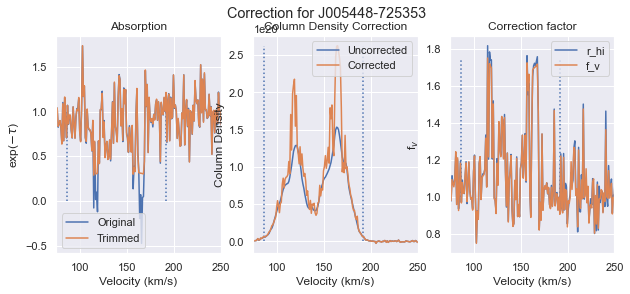

In [4]:
spectra_table = read_spectra_table(spectra_cat_loc, beam_pattern_loc, noise_limit=0.3)


comp_name = 'J005448-725353'
source = spectra_table[spectra_table['comp_name'] == comp_name]
#img_nh, tot_nh, tot_corr_nh, r_hi, ew, mean_ts, sd_cont, f_int_v = process_spectrum(source[0], 'sb10944/v3a/spectra', plot=True, use_em_filter=False)
spectra_stats = process_spectrum(source[0], 'sb10944/v3b/spectra', plot=True, smooth_thresh=20, use_em_filter=True, report_settings=True)
plt.savefig('figures/column_density_processing.png')
print (("image n_h = {:.3E} GASKAP uncorr n_h = {:.3E} +{:.3E} -{:.3E}  corr n_h= {:.3E} +{:.3E} -{:.3E} " +
        "R_HI_corr={:.3f} +{:.3f} -{:.3E} GASKAP/GASS N_H={:.3f} f_int(D00)={:.3f} ew={:3E} +{:3E} -{:3E} <T_S>={:.3f} +{:.3f} -{:.3f} old sd_cont={:.3f} new sd_cont={:.3f} chans={}").format(
    spectra_stats.img_nh, spectra_stats.tot_uncorr_nh, spectra_stats.e_tot_uncorr_nh_high, spectra_stats.e_tot_uncorr_nh_low, spectra_stats.tot_corr_nh, 
    spectra_stats.e_tot_corr_nh_high, spectra_stats.e_tot_corr_nh_low, spectra_stats.r_hi, spectra_stats.e_r_hi_high, spectra_stats.e_r_hi_low, spectra_stats.tot_uncorr_nh/spectra_stats.img_nh, 
    spectra_stats.f_int_v, spectra_stats.ew, spectra_stats.e_ew_high, spectra_stats.e_ew_low, 
    spectra_stats.mean_ts, spectra_stats.e_mean_ts_high, spectra_stats.e_mean_ts_low, source['sd_cont'][0],spectra_stats.sd_cont, spectra_stats.num_chan))



In [5]:

def add_column_density_to_spectra_table(spectra_loc, spectra_table):
    print (len(spectra_table))
    all_tot_uncorr_nh = np.zeros(len(spectra_table))
    all_e_tot_uncorr_nh_high = np.zeros(len(spectra_table))
    all_e_tot_uncorr_nh_low = np.zeros(len(spectra_table))
    all_corr_nh = np.zeros(len(spectra_table))
    all_e_corr_nh_high = np.zeros(len(spectra_table))
    all_e_corr_nh_low = np.zeros(len(spectra_table))
    all_img_nh = np.zeros(len(spectra_table))
    all_r_hi = np.zeros(len(spectra_table))
    all_e_r_hi_high = np.zeros(len(spectra_table))
    all_e_r_hi_low = np.zeros(len(spectra_table))
    all_ew = np.zeros(len(spectra_table))
    all_e_ew_high = np.zeros(len(spectra_table))
    all_e_ew_low = np.zeros(len(spectra_table))
    all_mean_ts = np.zeros(len(spectra_table))
    all_e_mean_ts_high = np.zeros(len(spectra_table))
    all_e_mean_ts_low = np.zeros(len(spectra_table))
    all_sd_cont = np.zeros(len(spectra_table))
    all_f_int =  np.zeros(len(spectra_table))
    all_num_chan = np.zeros(len(spectra_table))


    for idx, source in enumerate(spectra_table):
        if idx % 50 == 0:
            print ('processing record {} of {}'.format(idx+1, len(spectra_table)))
        #img_nh, tot_nh, tot_corr_nh, r_hi, ew, mean_ts, sd_cont, f_int_v = process_spectrum(source, 'sb10944/v3a/spectra', use_em_filter=False)
        spectra_stats = process_spectrum(source, spectra_loc, smooth_thresh=20, use_em_filter=True, report_settings=idx==0)
        if spectra_stats is None or spectra_stats.r_hi is None:
            print (source['comp_name'])
        all_tot_uncorr_nh[idx] = spectra_stats.tot_uncorr_nh
        all_e_tot_uncorr_nh_high[idx] = spectra_stats.e_tot_uncorr_nh_high
        all_e_tot_uncorr_nh_low[idx] = spectra_stats.e_tot_uncorr_nh_low

        all_corr_nh[idx] = spectra_stats.tot_corr_nh
        all_e_corr_nh_high[idx] = spectra_stats.e_tot_corr_nh_high
        all_e_corr_nh_low[idx] = spectra_stats.e_tot_corr_nh_low

        all_img_nh[idx] = spectra_stats.img_nh
        all_r_hi[idx] = spectra_stats.r_hi
        all_e_r_hi_high[idx] = spectra_stats.e_r_hi_high
        all_e_r_hi_low[idx] = spectra_stats.e_r_hi_low

        all_ew[idx] = spectra_stats.ew
        all_e_ew_high[idx] = spectra_stats.e_ew_high
        all_e_ew_low[idx] = spectra_stats.e_ew_low

        all_mean_ts[idx]= spectra_stats.mean_ts
        all_e_mean_ts_high[idx]= spectra_stats.e_mean_ts_high
        all_e_mean_ts_low[idx]= spectra_stats.e_mean_ts_low

        all_sd_cont[idx] = spectra_stats.sd_cont
        all_f_int[idx] = spectra_stats.f_int_v
        all_num_chan[idx] = spectra_stats.num_chan
        if source['comp_name'] == 'J011402-732007':
            print (spectra_stats)
            print (spectra_table[idx]['comp_name'])
    print (idx)

    spectra_table.add_column(Column(name='nh_uncorr', data=all_tot_uncorr_nh, unit=u.cm**-2, 
                                description='Uncorrected column density as measured from the emission spectrum'))
    spectra_table.add_column(Column(name='e_nh_uncorr_high', data=all_e_tot_uncorr_nh_high, unit=u.cm**-2, 
                                description='The positive uncertainty in the uncorrected column density as measured from the emission spectrum'))
    spectra_table.add_column(Column(name='e_nh_uncorr_low', data=all_e_tot_uncorr_nh_low, unit=u.cm**-2, 
                                description='The negative uncertainty in the uncorrected column density as measured from the emission spectrum'))

    spectra_table.add_column(Column(name='nh_corr', data=all_corr_nh, unit=u.cm**-2, 
                                    description='Absorption corrected column density as measured from the emission spectrum'))
    spectra_table.add_column(Column(name='e_nh_corr_high', data=all_e_corr_nh_high, unit=u.cm**-2, 
                                    description='The positive uncertainty in the absorption corrected column density as measured from the emission spectrum'))
    spectra_table.add_column(Column(name='e_nh_corr_low', data=all_e_corr_nh_low, unit=u.cm**-2, 
                                    description='The negative uncertainty in the absorption corrected column density as measured from the emission spectrum'))

    spectra_table.add_column(Column(name='r_hi', data=all_r_hi, 
                                    description='Ratio of uncorrected to corrected column density'))
    spectra_table.add_column(Column(name='e_r_hi_high', data=all_e_r_hi_high, 
                                    description='The positive uncertainty in the ratio of uncorrected to corrected column density'))
    spectra_table.add_column(Column(name='e_r_hi_low', data=all_e_r_hi_low, 
                                    description='The negative uncertainty in the ratio of uncorrected to corrected column density'))


    spectra_table.add_column(Column(name='f_int', data=all_f_int, 
                                    description='Dickey et al 2000 ratio of uncorrected to corrected column density'))
    spectra_table.add_column(Column(name='mean_ts', data=all_mean_ts, 
                                    description='Density-weighted mean spin temperature'))
    spectra_table.add_column(Column(name='e_mean_ts_high', data=all_e_mean_ts_high, 
                                    description='The positive uncertainty in the density-weighted mean spin temperature'))
    spectra_table.add_column(Column(name='e_mean_ts_low', data=all_e_mean_ts_low, 
                                    description='The negative uncertainty in the density-weighted mean spin temperature'))


    spectra_table.add_column(Column(name='ew', data=all_ew, unit=u.km/u.s,
                                    description='Integral of absorption (tau) across the emission velocity range'))
    spectra_table.add_column(Column(name='e_ew_high', data=all_e_ew_high, unit=u.km/u.s,
                                    description='The positive uncertainty in the integral of absorption (tau) across the emission velocity range'))
    spectra_table.add_column(Column(name='e_ew_low', data=all_e_ew_low, unit=u.km/u.s,
                                    description='The negative uncertainty in the integral of absorption (tau) across the emission velocity range'))


    spectra_table.add_column(Column(name='num_chan', data=all_num_chan, 
                                    description='Number of chanels in the emission box used for column density etc analysis.'))

    print (spectra_table[spectra_table['comp_name']=='J011402-732007'])
    
    filename = 'gaskap_smc_spectra.vot'
    spectra_table.write(filename, table_id='gaskap_smc_spectra', format='votable', overwrite=True)
    print ('Wrote augmented spectra table to', filename)

    
add_column_density_to_spectra_table(spectra_loc, spectra_table)


229
processing record 1 of 229
Spectrum settings: Em box:True, Smoothing with noise > 20,velocity 75 - 250 km/s


/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_9838/1572413030.py:64: RuntimeWarning: invalid value encountered in true_divide
  r_hi_all = np.sum(nh_corr[:,vel_filter], axis=1) / np.sum(nh_uncorr[:,vel_filter], axis=1)
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_9838/1572413030.py:80: RuntimeWarning: invalid value encountered in true_divide
  mean_ts_all = tot_em / tot_od
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_9838/1136476711.py:53: UserWarning: Warning: converting a masked element to nan.
  all_f_int[idx] = spectra_stats.f_int_v
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_9838/1572413030.py:64: RuntimeWarning: invalid value encountered in true_divide
  r_hi_all = np.sum(nh_corr[:,vel_filter], axis=1) / np.sum(nh_uncorr[:,vel_filter], axis=1)
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_9838/1572413030.py:80: RuntimeWarning: invalid value encountered in true_divide
  mean_ts_all = tot_em / tot_od
/var/folders/

processing record 51 of 229


/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_9838/1572413030.py:64: RuntimeWarning: invalid value encountered in true_divide
  r_hi_all = np.sum(nh_corr[:,vel_filter], axis=1) / np.sum(nh_uncorr[:,vel_filter], axis=1)
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_9838/1572413030.py:80: RuntimeWarning: invalid value encountered in true_divide
  mean_ts_all = tot_em / tot_od
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_9838/1136476711.py:53: UserWarning: Warning: converting a masked element to nan.
  all_f_int[idx] = spectra_stats.f_int_v


SpectraStats(img_nh=4.76657045014257e+21, tot_uncorr_nh=6.068824502184154e+21, e_tot_uncorr_nh_high=5.1594758479850504e+19, e_tot_uncorr_nh_low=5.22268010841899e+19, tot_corr_nh=8.896978139956052e+21, e_tot_corr_nh_high=3.1413990828495654e+20, e_tot_corr_nh_low=2.3644297933833214e+20, r_hi=1.4654285301041634, e_r_hi_high=0.05193912447377036, e_r_hi_low=0.036440080733241675, ew=28.289376757963325, e_ew_high=2.03657039874594, e_ew_low=1.6111656748528678, mean_ts=210.21636395335418, e_mean_ts_high=15.688191555189974, e_mean_ts_low=12.438082090430242, sd_cont=0.08206335, f_int_v=1.4393203714877363, num_chan=89)
J011402-732007


/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_9838/1572413030.py:64: RuntimeWarning: invalid value encountered in true_divide
  r_hi_all = np.sum(nh_corr[:,vel_filter], axis=1) / np.sum(nh_uncorr[:,vel_filter], axis=1)
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_9838/1572413030.py:80: RuntimeWarning: invalid value encountered in true_divide
  mean_ts_all = tot_em / tot_od
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_9838/1136476711.py:53: UserWarning: Warning: converting a masked element to nan.
  all_f_int[idx] = spectra_stats.f_int_v
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_9838/1572413030.py:64: RuntimeWarning: invalid value encountered in true_divide
  r_hi_all = np.sum(nh_corr[:,vel_filter], axis=1) / np.sum(nh_uncorr[:,vel_filter], axis=1)
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_9838/1572413030.py:80: RuntimeWarning: invalid value encountered in true_divide
  mean_ts_all = tot_em / tot_od
/var/folders/

processing record 101 of 229


/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_9838/1572413030.py:64: RuntimeWarning: invalid value encountered in true_divide
  r_hi_all = np.sum(nh_corr[:,vel_filter], axis=1) / np.sum(nh_uncorr[:,vel_filter], axis=1)
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_9838/1572413030.py:80: RuntimeWarning: invalid value encountered in true_divide
  mean_ts_all = tot_em / tot_od
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_9838/1136476711.py:53: UserWarning: Warning: converting a masked element to nan.
  all_f_int[idx] = spectra_stats.f_int_v
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_9838/1572413030.py:64: RuntimeWarning: invalid value encountered in true_divide
  r_hi_all = np.sum(nh_corr[:,vel_filter], axis=1) / np.sum(nh_uncorr[:,vel_filter], axis=1)
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_9838/1572413030.py:80: RuntimeWarning: invalid value encountered in true_divide
  mean_ts_all = tot_em / tot_od
/var/folders/

processing record 151 of 229


/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_9838/1572413030.py:64: RuntimeWarning: invalid value encountered in true_divide
  r_hi_all = np.sum(nh_corr[:,vel_filter], axis=1) / np.sum(nh_uncorr[:,vel_filter], axis=1)
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_9838/1572413030.py:80: RuntimeWarning: invalid value encountered in true_divide
  mean_ts_all = tot_em / tot_od
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_9838/1136476711.py:53: UserWarning: Warning: converting a masked element to nan.
  all_f_int[idx] = spectra_stats.f_int_v
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_9838/1572413030.py:64: RuntimeWarning: invalid value encountered in true_divide
  r_hi_all = np.sum(nh_corr[:,vel_filter], axis=1) / np.sum(nh_uncorr[:,vel_filter], axis=1)
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_9838/1572413030.py:80: RuntimeWarning: invalid value encountered in true_divide
  mean_ts_all = tot_em / tot_od
/var/folders/

processing record 201 of 229


/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_9838/1572413030.py:64: RuntimeWarning: invalid value encountered in true_divide
  r_hi_all = np.sum(nh_corr[:,vel_filter], axis=1) / np.sum(nh_uncorr[:,vel_filter], axis=1)
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_9838/1572413030.py:80: RuntimeWarning: invalid value encountered in true_divide
  mean_ts_all = tot_em / tot_od
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_9838/1136476711.py:53: UserWarning: Warning: converting a masked element to nan.
  all_f_int[idx] = spectra_stats.f_int_v
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_9838/1572413030.py:64: RuntimeWarning: invalid value encountered in true_divide
  r_hi_all = np.sum(nh_corr[:,vel_filter], axis=1) / np.sum(nh_uncorr[:,vel_filter], axis=1)
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_9838/1572413030.py:80: RuntimeWarning: invalid value encountered in true_divide
  mean_ts_all = tot_em / tot_od
/var/folders/

228
 id   comp_name        ra       dec            glon               glat        rating ...   e_mean_ts_high     e_mean_ts_low            ew            e_ew_high          e_ew_low      num_chan
                      deg       deg                                                  ...                                             km / s            km / s            km / s               
--- -------------- --------- ---------- ----------------- ------------------- ------ ... ------------------ ------------------ ------------------ ---------------- ------------------ --------
 90 J011402-732007 18.511691 -73.335424 300.6932167765954 -43.694415945131176      B ... 15.688191555189974 12.438082090430242 28.289376757963325 2.03657039874594 1.6111656748528678     89.0
Wrote augmented spectra table to gaskap_smc_spectra.vot


### Produce restricted absorption table

In [6]:
spec_tab = parse_single_table('gaskap_smc_spectra.vot').to_table()
abs_tab = parse_single_table(absorption_cat_loc).to_table()

retained = np.isin(abs_tab['comp_name'], spec_tab['comp_name'])

print ("Of {} features, {} are retained.".format(len(abs_tab), np.sum(retained)))

abs_tab_trimmed = abs_tab[retained]

filename = 'gaskap_smc_absorption.vot'
abs_tab_trimmed.write(filename, table_id='gaskap_smc_absorption', format='votable', overwrite=True)
print ('Wrote trimmed absoprtion table to', filename)

Of 134 features, 130 are retained.
Wrote trimmed absoprtion table to gaskap_smc_absorption.vot
